In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy as deep
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Preprocessing

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/데이터마이닝 (분류)/WA_Fn-UseC_-Telco-Customer-Churn.csv')

df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
del df["customerID"]
df.drop(df[df.TotalCharges == " "].index, inplace=True)
df["TotalCharges"] = df["TotalCharges"].astype("float64")
df["TotalCharges"] = df["TotalCharges"].astype("int64")
df["MonthlyCharges"] = df["MonthlyCharges"].astype("int64")

color_list = ['#E03A3E','#61BB46', '#009DDC', '#F5821F', '#963D97']

df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29,29,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56,1889,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53,108,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42,1840,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70,151,Yes


# Check Data

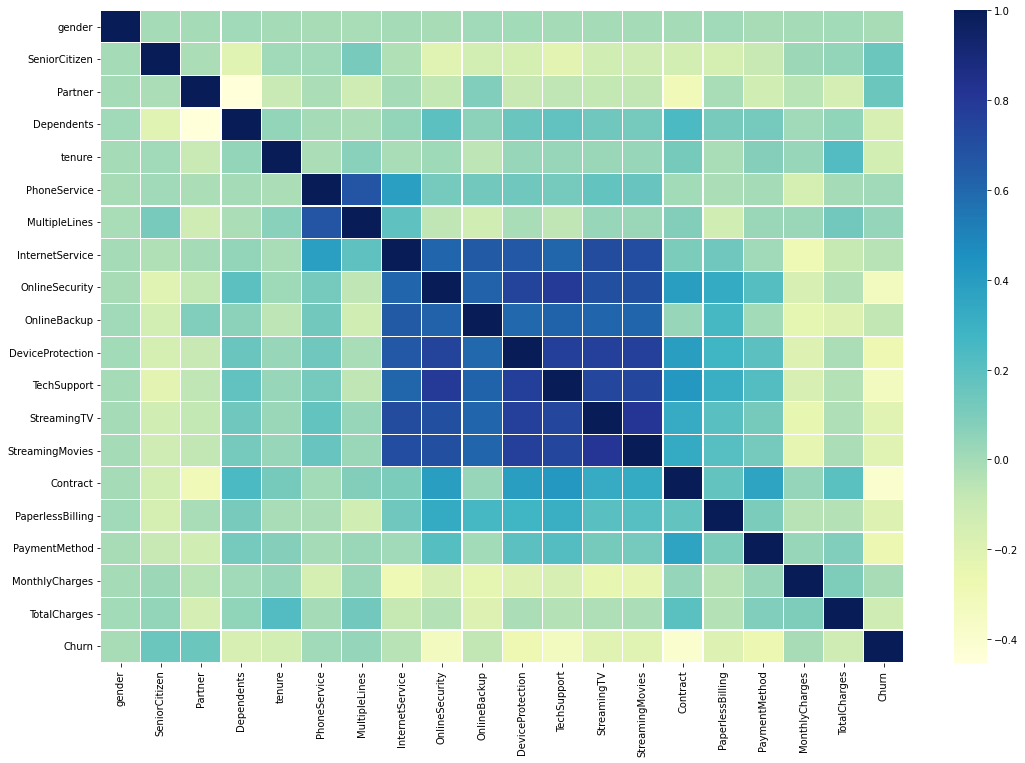

In [5]:
plt.figure(figsize=(18, 12))
corr = df.apply(lambda x: pd.factorize(x)[0]).corr()
ax = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, linewidths=.2, cmap= "YlGnBu")

## Continuous values

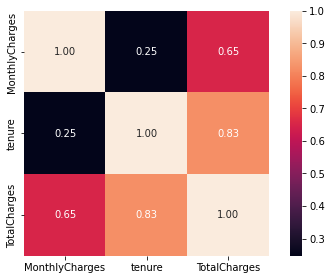

In [6]:
Continuous = ["MonthlyCharges", "tenure", "TotalCharges"]

coef = np.corrcoef(df[Continuous].values.T)
hm = sns.heatmap(
    coef,
    cbar=True,
    annot=True,
    square=True,
    fmt=".2f",
    yticklabels=Continuous,
    xticklabels=Continuous,
)
plt.tight_layout()
plt.show()

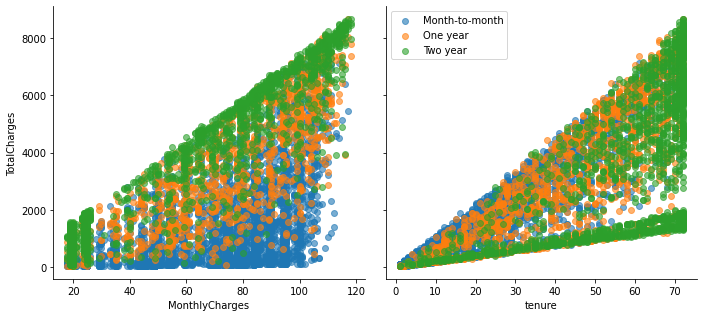

In [7]:
g = sns.PairGrid(df, y_vars=["TotalCharges"], x_vars=["MonthlyCharges", "tenure"], height=4.5, hue="Contract", aspect=1.1)
ax = g.map(plt.scatter, alpha=0.6)
plt.legend(loc="upper left")

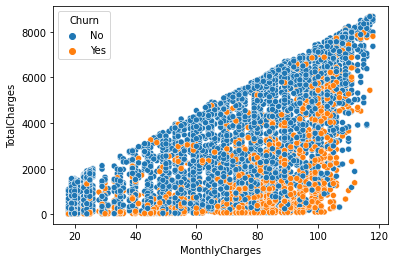

In [8]:
ax = sns.scatterplot(data=df, y="TotalCharges", x="MonthlyCharges", hue="Churn")

tenure           1    2    3    4    5   6    7   ...  66  67  68  69  70   71   72
Contract                                          ...                              
Month-to-month  604  230  191  165  128  95  113  ...  11   8  10   6   4    5    2
One year          7    7    6    7    4   7   14  ...  35  34  25  23  27   28   17
Two year          2    1    3    4    1   8    4  ...  43  56  65  66  88  137  343

[3 rows x 72 columns]


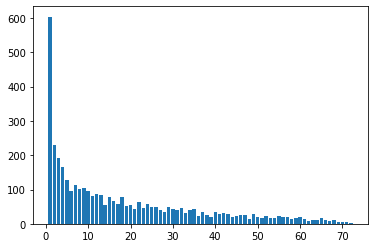

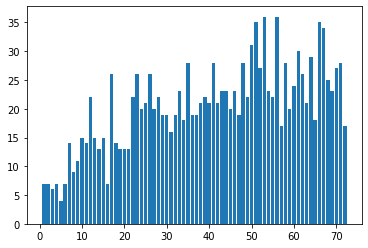

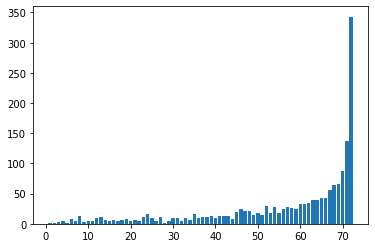

In [9]:
tenure_Contract = df.groupby(['Contract','tenure']).size().unstack()
print(tenure_Contract)

for index in df["Contract"].unique():
    plt.bar(x=tenure_Contract.columns, height=tenure_Contract.loc[index, :].values)
    plt.show()

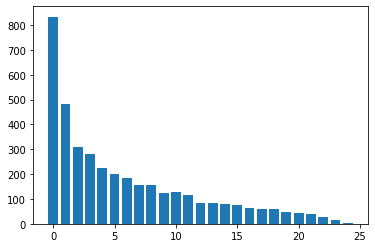

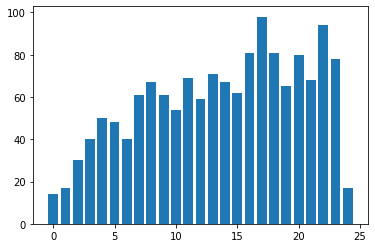

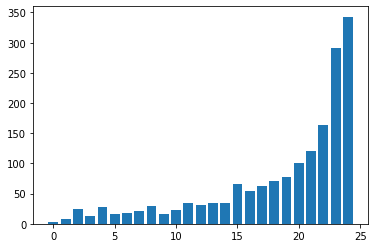

In [10]:
tenure_Contract2 = df.groupby(['Contract','tenure']).size().unstack()

test=pd.DataFrame(index=["Month-to-month", "One year", "Two year" ], columns=np.arange(0,25))
test = test.fillna(0)
for churn in ["Month-to-month","One year","Two year" ]:
    for column in tenure_Contract2.columns:
        test.loc[churn, column // 3] += tenure_Contract2.loc[churn, column]

for index in df["Contract"].unique():
    plt.bar(x=test.columns, height=test.loc[index, :].values)
    plt.show()
# Combinning 3 months to see if there is any difference

# Applying ML to df1(has every columns)

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
# from sklearn.svm import SVR

model_list = []
model_list.append((LogisticRegression(solver='liblinear'), "LR"))
model_list.append((DecisionTreeClassifier(), "DT"))
model_list.append((KNeighborsClassifier(), "KNN"))
model_list.append((RandomForestClassifier(), "RFC"))
model_list.append((GaussianNB(), "GNB"))

In [12]:
from sklearn import preprocessing

df_OH = df.copy()

encoder = preprocessing.LabelEncoder()

temp = []

for column in df_OH.columns:
    if len(df_OH[column].unique()) <= 4:
        temp.append(column)
        
del temp[-1]
df_OH = pd.get_dummies(df_OH, columns=temp)
encoder.fit(df_OH["Churn"])
df_OH["Churn"] = encoder.transform(df_OH["Churn"])

In [13]:
from sklearn import preprocessing

df_LE = df.copy()

encoder = preprocessing.LabelEncoder()

for column in df_LE.columns:
    if len(df_LE[column].unique()) <= 4:
        encoder.fit(df_LE[column])
        df_LE[column] = encoder.transform(df_LE[column])

## Check relation between churn and other columns

In [14]:
def remove_item(model_list, string):
    for model, label in model_list:
        if(label == string):
            model_list.remove((model, label))

In [15]:
x_and_y = []

X_OH, y_OH = df_OH.loc[:, df_OH.columns != "Churn"].values, df_OH["Churn"].values
X_LE, y_LE = df_LE.loc[:, df_LE.columns != "Churn"].values, df_LE["Churn"].values

new_columns_OH = list(df_OH.columns)
new_columns_OH.remove("Churn")
new_columns_LE = list(df_LE.columns)
new_columns_LE.remove("Churn")

x_and_y.append((X_OH, y_OH, "OH", new_columns_OH))
x_and_y.append((X_LE, y_LE, "LE", new_columns_LE))

In [16]:
from sklearn.feature_selection import RFE

def RFE_Func(X, y, model, columns):
    selector = RFE(model, n_features_to_select=5, step=1)
    selector = selector.fit(X, y)
    test = pd.DataFrame(selector.support_)
    # print(test.columns)
    test["columns"] = columns
    test["ranking"] = selector.ranking_
    test["support"] = selector.support_
    test = test.loc[test["support"] == True, ["columns"]]
    print(test, "\n")

In [17]:
temp = deep(model_list)
remove_item(temp, "KNN")
remove_item(temp, "GNB")

for model, mod_name in temp:
    print("--------------------------",mod_name, "------------------------------")
    for x,y,data_name,columns in x_and_y:
        print(data_name)
        RFE_Func(x,y,model, columns)

-------------------------- LR ------------------------------
OH
                                columns
16                  InternetService_DSL
32      StreamingTV_No internet service
35  StreamingMovies_No internet service
37              Contract_Month-to-month
39                    Contract_Two year 

LE
             columns
3         Dependents
8     OnlineSecurity
11       TechSupport
14          Contract
15  PaperlessBilling 

-------------------------- DT ------------------------------
OH
                        columns
0                        tenure
1                MonthlyCharges
2                  TotalCharges
17  InternetService_Fiber optic
37      Contract_Month-to-month 

LE
           columns
4           tenure
14        Contract
16   PaymentMethod
17  MonthlyCharges
18    TotalCharges 

-------------------------- RFC ------------------------------
OH
                    columns
0                    tenure
1            MonthlyCharges
2              TotalCharges
19       

Feature: MonthlyCharges       Score: 0.11 
Feature: Churn                Score: 0.06 
Feature: gender               Score: 0.03 
Feature: TotalCharges         Score: 0.02 
Feature: PaperlessBilling     Score: 0.01 
Feature: SeniorCitizen        Score: 0.01 
Feature: StreamingMovies      Score: 0.01 
Feature: Partner              Score: 0.01 
Feature: PaymentMethod        Score: 0.01 
Feature: PhoneService         Score: 0.01 
Feature: TechSupport          Score: 0.01 
Feature: OnlineBackup         Score: 0.01 
Feature: Dependents           Score: 0.00 
Feature: InternetService      Score: 0.00 
Feature: tenure               Score: 0.00 
Feature: MultipleLines        Score: 0.00 
Feature: OnlineSecurity       Score: 0.00 
Feature: DeviceProtection     Score: 0.00 
Feature: StreamingTV          Score: 0.00 
Feature: Contract             Score: 0.00 


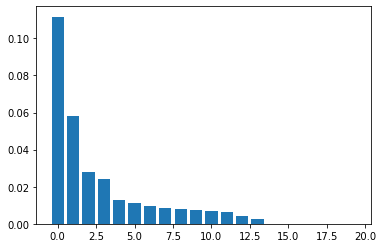

In [18]:
import xgboost

def sort_print(importance, columns):
    zipped = zip(importance, columns)
    sorted_zip = sorted(zipped, key=lambda x: x[0], reverse=True)
    importance, columns = zip(*sorted_zip)

    for column, score in zip(columns, importance):
        print("Feature: {: <20} Score: {: <5.2f}".format(column, score))

    plt.bar([x for x in range(len(importance))], importance)
    plt.show()


X, y = df_OH.loc[:, df_OH.columns != "Churn"].values, df_OH["Churn"].values
model = xgboost.XGBClassifier()
model.fit(X, y)
importance = model.feature_importances_

sort_print(importance, df.columns)

## Based on importances, we defined new dataset, extracting some of the columns

In [19]:
df2 = df[
    [
        "TotalCharges",
        "tenure",
        "Contract",
        "MonthlyCharges",
        "PaymentMethod",
        "OnlineSecurity",
        "Churn"
    ]
]

encoder = preprocessing.LabelEncoder()

Nominal = ["Contract", "PaymentMethod", "OnlineSecurity", "Churn"]

for column in Nominal:
    encoder.fit(df2.loc[:, column])
    df2[column] = encoder.transform(df2.loc[:, column])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [20]:
X2, y2 = df2.loc[:, df2.columns != "Churn"].values, df2["Churn"].values

new_columns2 = list(df2.columns)
new_columns2.remove("Churn")

x_and_y.append((X2, y2, "Extract", new_columns2))

## Performance

In [21]:
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import cross_val_score

def cross_sKF(X,y, model_):
  sKF = StratifiedKFold(n_splits=10)
  scores = cross_val_score(model_, X, y, cv=sKF)
    
  print("Mean: {:.3f} +- {:.4f}".format(np.mean(scores), np.var(scores),))

In [22]:
# cross_sKF(X_LE, y_LE, LinearRegression())
temp = deep(model_list)
# remove_item(temp,"LR")
remove_item(temp,"SVM")

for model, label in temp:
    print(label)
    for x,y,label,dummy in x_and_y:
        print(label,  end=" - ")
        cross_sKF(x,y,model)

LR
OH - Mean: 0.803 +- 0.0001
LE - Mean: 0.804 +- 0.0001
Extract - Mean: 0.787 +- 0.0002
DT
OH - Mean: 0.728 +- 0.0002
LE - Mean: 0.730 +- 0.0003
Extract - Mean: 0.727 +- 0.0001
KNN
OH - Mean: 0.758 +- 0.0002
LE - Mean: 0.759 +- 0.0001
Extract - Mean: 0.761 +- 0.0001
RFC
OH - Mean: 0.790 +- 0.0003
LE - Mean: 0.792 +- 0.0002
Extract - Mean: 0.773 +- 0.0002
GNB
OH - Mean: 0.695 +- 0.0004
LE - Mean: 0.753 +- 0.0001
Extract - Mean: 0.724 +- 0.0001


## Found out extracting columns doesn't help.
## But thought, "what if we combine services into one column?"

In [23]:
Services = ["OnlineSecurity","OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies"]

df3 = df.copy()
df3["Service"] = df3[Services].eq("Yes").sum(axis=1)
# Summed up number of service customers using
for col_name in Services:
    del df3[col_name]
del df3["InternetService"]
print(df3.columns)

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn', 'Service'],
      dtype='object')


In [24]:
df3.loc[:,"Service"]

0       1
1       2
2       2
3       3
4       0
       ..
7038    5
7039    4
7040    1
7041    0
7042    5
Name: Service, Length: 7032, dtype: int64

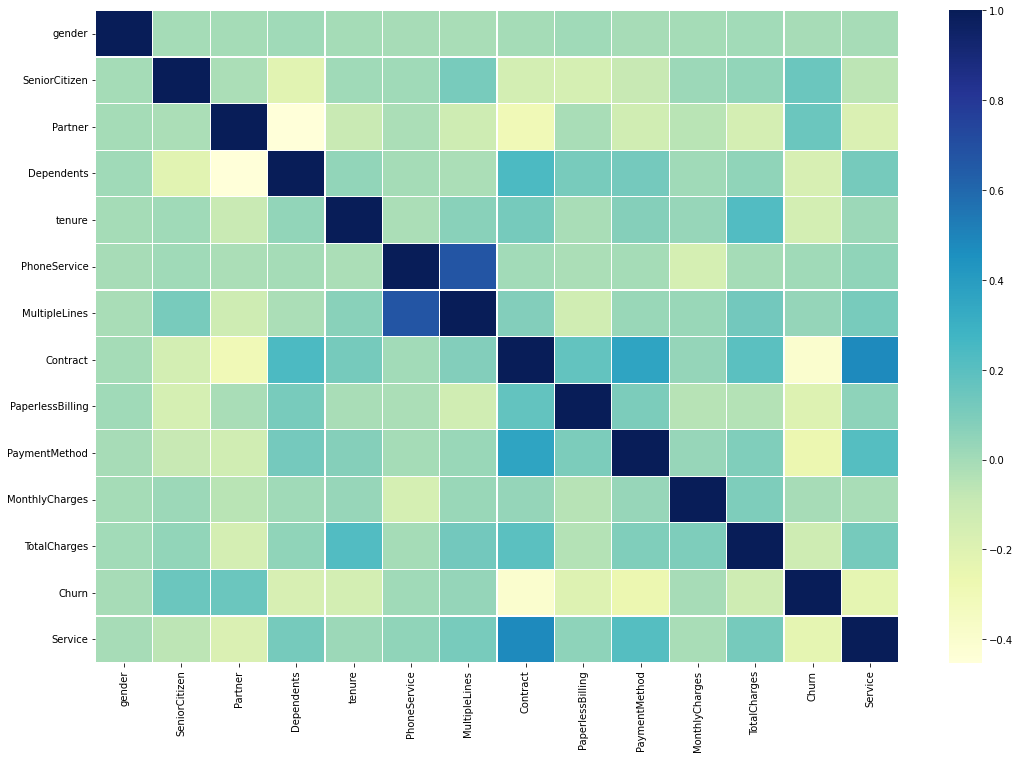

In [25]:
plt.figure(figsize=(18, 12))
corr = df3.apply(lambda x: pd.factorize(x)[0]).corr()
ax = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, 
                 linewidths=.2, cmap="YlGnBu")

In [26]:
df3_OH = df3.copy()
temp = list(df3.columns)
for col_name in Continuous:
    print(col_name)
    temp.remove(col_name)
temp.remove("Churn")

df3_OH = pd.get_dummies(df3_OH, columns=temp)
encoder = preprocessing.LabelEncoder()
encoder.fit(df3_OH["Churn"])
df3_OH["Churn"] = encoder.transform(df3_OH["Churn"])

X3_OH , y3_OH = df3_OH.loc[:, df3_OH.columns != "Churn"].values , df3_OH["Churn"].values
new_columns_3OH = list(df3_OH.columns)
new_columns_3OH.remove("Churn")
x_and_y.append((X3_OH, y3_OH, "Unite_OH", new_columns_3OH))

MonthlyCharges
tenure
TotalCharges


In [27]:
df3_LE = df3.copy()
encoder = preprocessing.LabelEncoder()

temp = list(df3_LE.columns)
for col_name in Continuous:
    temp.remove(col_name)

for col_name in temp:
    encoder.fit(df3_LE[col_name])
    df3_LE[col_name] = encoder.transform(df3_LE[col_name])
    
X3_LE , y3_LE = df3_LE.loc[:, df3_LE.columns != "Churn"].values , df3_LE["Churn"].values
new_columns_3LE = list(df3_LE.columns)
new_columns_3LE.remove("Churn")
x_and_y.append((X3_LE, y3_LE, "Unite_LE", new_columns_3LE))

## Check performance again

In [28]:
temp = deep(model_list)
# remove_item(temp,"LR")
remove_item(temp,"SVM")

for model, label in temp:
    print(label)
    for x,y,label,dummy in x_and_y:
        print(label,  end=" - ")
        cross_sKF(x,y,model)

LR
OH - Mean: 0.803 +- 0.0001
LE - Mean: 0.804 +- 0.0001
Extract - Mean: 0.787 +- 0.0002
Unite_OH - Mean: 0.802 +- 0.0001
Unite_LE - Mean: 0.802 +- 0.0002
DT
OH - Mean: 0.727 +- 0.0002
LE - Mean: 0.729 +- 0.0003
Extract - Mean: 0.727 +- 0.0001
Unite_OH - Mean: 0.725 +- 0.0001
Unite_LE - Mean: 0.726 +- 0.0001
KNN
OH - Mean: 0.758 +- 0.0002
LE - Mean: 0.759 +- 0.0001
Extract - Mean: 0.761 +- 0.0001
Unite_OH - Mean: 0.759 +- 0.0002
Unite_LE - Mean: 0.760 +- 0.0001
RFC
OH - Mean: 0.792 +- 0.0003
LE - Mean: 0.789 +- 0.0003
Extract - Mean: 0.776 +- 0.0002
Unite_OH - Mean: 0.788 +- 0.0003
Unite_LE - Mean: 0.789 +- 0.0003
GNB
OH - Mean: 0.695 +- 0.0004
LE - Mean: 0.753 +- 0.0001
Extract - Mean: 0.724 +- 0.0001
Unite_OH - Mean: 0.703 +- 0.0001
Unite_LE - Mean: 0.730 +- 0.0001


------------------------ OH ------------------------


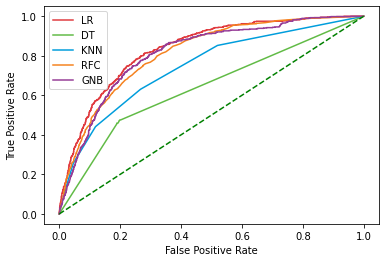

<Figure size 1296x864 with 0 Axes>

------------------------ LE ------------------------


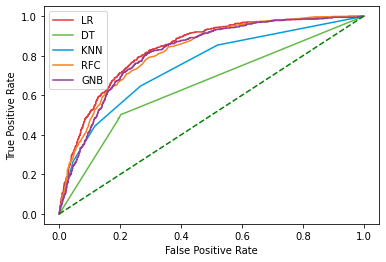

<Figure size 1296x864 with 0 Axes>

------------------------ Extract ------------------------


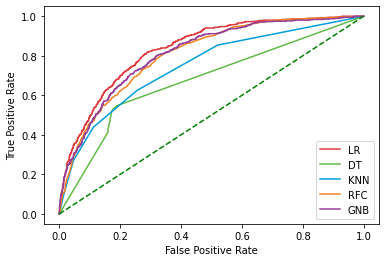

<Figure size 1296x864 with 0 Axes>

------------------------ Unite_OH ------------------------


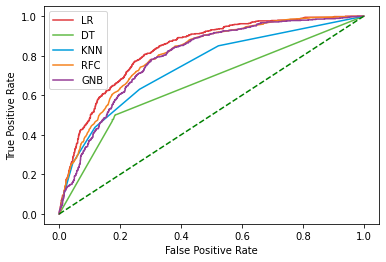

<Figure size 1296x864 with 0 Axes>

------------------------ Unite_LE ------------------------


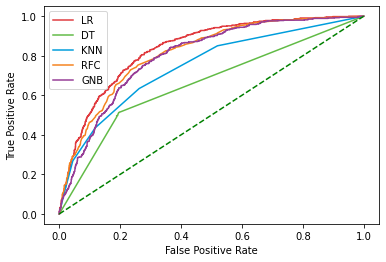

<Figure size 1296x864 with 0 Axes>

In [29]:
from itertools import cycle
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split

def ROC_Func_LoopMod(X,y,m_model_list):   
    train_X, test_X, train_y, test_y = train_test_split(X,y, test_size=0.3, random_state=0)
    
    colors = cycle(['#E03A3E','#61BB46', '#009DDC', '#F5821F', '#963D97'])
    for (model, label) , color in zip(m_model_list,colors):
        model.fit(train_X, train_y)

        probs = model.predict_proba(test_X)
        prob = probs[:, 1]
        fper, tper, thresholds = roc_curve(test_y, prob)
        plt.plot(fper, tper, color=color, label=label)
        
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.figure(figsize=(18, 12))
    plt.show()
    
for X,y,label, dummy in x_and_y:
    print("------------------------", label, "------------------------")
    ROC_Func_LoopMod(X, y, temp)

## Better than extract but not the best
## So we decided to use Labelencoded, pure data set

# Hyper parameter tunning
## In this proejct we used hyperopt

In [30]:
from yellowbrick.contrib.classifier import DecisionViz

def Plot_Boundary(model, model_label, bundle):  
    x_train, x_test, y_train, y_test = bundle
    viz = DecisionViz(
    model, title=model_label,
    features=["MonthlyCharges","TotalCharges"], classes=['No', 'Yes']
    )
    viz.fit(x_train, y_train)
    viz.draw(x_test, y_test)
    viz.show()
    
def get_score(model):
    acc = cross_val_score(model, X_LE, y_LE,scoring="accuracy").mean()
    rec = cross_val_score(model, X_LE, y_LE,scoring="recall").mean()
    prec = cross_val_score(model, X_LE, y_LE,scoring="precision").mean()
    
    print("accuracy : ", acc)
    print("recall : ", rec)
    print("precision : ", prec)

In [31]:
model_list2 =[]
model_list2_enhanced = []

In [32]:
from hyperopt import tpe, hp, fmin, STATUS_OK, Trials
from hyperopt.pyll.base import scope
from sklearn import metrics
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

space = {
            'warm_start' : hp.choice('warm_start', [True, False]),
            'fit_intercept' : hp.choice('fit_intercept', [True, False]),
            'tol' : hp.uniform('tol', 0.00001, 0.0001),
            'C' : hp.uniform('C', 0.05, 3),
            'solver' : hp.choice('solver', ['newton-cg', 'lbfgs', 'liblinear']),
            'max_iter' : hp.choice('max_iter', range(100,1000)),
            'multi_class' : 'auto',
            'class_weight' : 'balanced'
            }

def obj_fnc_LR(params):
    clf = LogisticRegression(**params)
    acc = cross_val_score(clf, X_LE, y_LE,scoring="accuracy").mean()
    return {"loss": acc, "status": STATUS_OK}

trials = Trials()
best_params = fmin(
    obj_fnc_LR, 
    space, 
    algo=tpe.suggest,
    max_evals=100,
    trials=trials)
print("Best: {}".format(best_params))

100%|██████████| 100/100 [02:13<00:00,  1.33s/it, best loss: 0.7403283319229903]
Best: {'C': 2.744778107802702, 'fit_intercept': 0, 'max_iter': 104, 'solver': 1, 'tol': 1.633163789163458e-05, 'warm_start': 1}


### Logistic regression

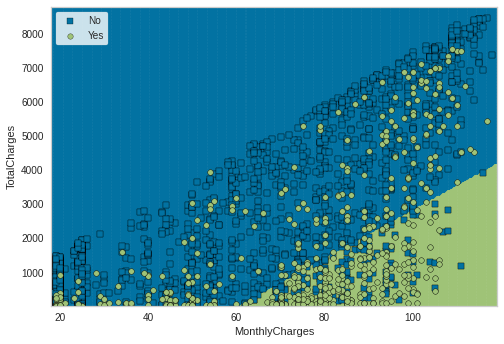

accuracy :  0.8011940905106656
recall :  0.5489498358446474
precision :  0.6489914628917977


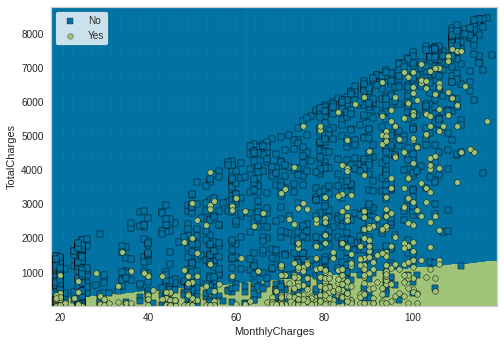

accuracy :  0.8011940905106656
recall :  0.5489498358446474
precision :  0.6489914628917977


In [33]:
model_LR = LogisticRegression()

X,y = df_LE.loc[:, ["MonthlyCharges","TotalCharges"]].values, df_LE.loc[:, "Churn"].values
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
bundle = (x_train, x_test, y_train, y_test)

Plot_Boundary(model_LR, model_label="LR", bundle=bundle)
get_score(model_LR)

model_list2.append(("LR", model_LR))

model_LR_enhan = LogisticRegression(
    C=2.2278549968960926,
    max_iter=255,
    solver= "liblinear",
    warm_start=False,
    fit_intercept=False,
    tol = 9.117046127986287e-05,
                           )

Plot_Boundary(model_LR_enhan, model_label="LR tunned", bundle=bundle)
get_score(model_LR)

model_list2_enhanced.append(("LR", model_LR_enhan))

In [34]:
space = {
            'n_neighbors': hp.choice('n_neighbors', range(1,100)),
            'leaf_size': hp.choice('leaf_size', range(1,100)),
            'p': hp.choice('p', [1, 2]),
            'weights': hp.choice('weights', ['uniform', 'distance']),
            }


def obj_fnc_KNN(params):
    # clf = models[model](**params)
    clf = KNeighborsClassifier(**params, n_jobs=-1)
    acc = cross_val_score(clf, X_LE, y_LE,scoring="accuracy").mean()
    return {"loss": -acc, "status": STATUS_OK}

trials = Trials()
best_params = fmin(
    obj_fnc_KNN, 
    space, 
    algo=tpe.suggest,
    max_evals=100,
    trials=trials)
print("Best: {}".format(best_params))

100%|██████████| 100/100 [02:34<00:00,  1.55s/it, best loss: -0.7871156309490953]
Best: {'leaf_size': 73, 'n_neighbors': 22, 'p': 0, 'weights': 0}


### KNN

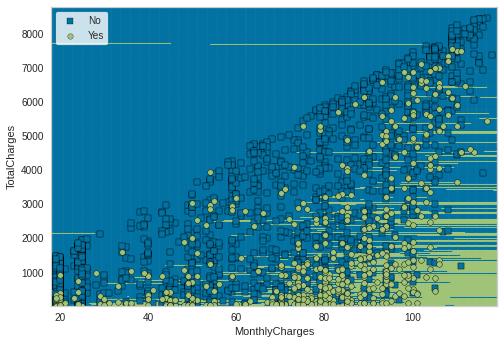

accuracy :  0.7578218438391259
recall :  0.4408653639374346
precision :  0.5564522064281342


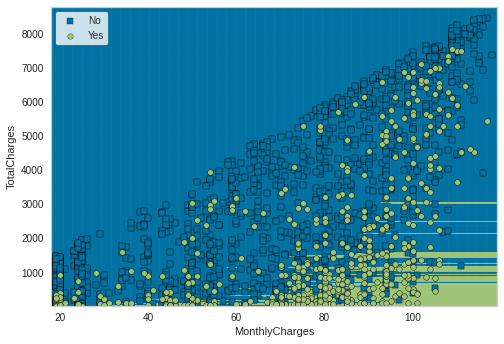

accuracy :  0.7852673232091928
recall :  0.3873707903829336
precision :  0.6656047074387585


In [35]:
model_KNN = KNeighborsClassifier()

model_list2.append(("KNN", model_KNN))

viz = DecisionViz(
    model_KNN, title="K nearest neighbor",
    features=["MonthlyCharges","TotalCharges"], classes=['No', 'Yes']
)
viz.fit(x_train, y_train)
viz.draw(x_test, y_test)
viz.show()

acc = cross_val_score(model_KNN, X_LE, y_LE,scoring="accuracy").mean()
rec = cross_val_score(model_KNN, X_LE, y_LE,scoring="recall").mean()
prec = cross_val_score(model_KNN, X_LE, y_LE,scoring="precision").mean()


print("accuracy : ", acc)
print("recall : ", rec)
print("precision : ", prec)

model_KNN_enhan = KNeighborsClassifier(
    leaf_size=2,
    n_neighbors = 22,
    p=1,
    weights='uniform'
    )

model_list2_enhanced.append(("KNN", model_KNN_enhan))

viz = DecisionViz(
    model_KNN_enhan, title="K nearest neighbor tunned",
    features=["MonthlyCharges","TotalCharges"], classes=['No', 'Yes']
)
viz.fit(x_train, y_train)
viz.draw(x_test, y_test)
viz.show()

acc = cross_val_score(model_KNN_enhan, X_LE, y_LE,scoring="accuracy").mean()
rec = cross_val_score(model_KNN_enhan, X_LE, y_LE,scoring="recall").mean()
prec = cross_val_score(model_KNN_enhan, X_LE, y_LE,scoring="precision").mean()

print("accuracy : ", acc)
print("recall : ", rec)
print("precision : ", prec)

### Random Forest Classifier

In [36]:
space = {
    'n_estimators' : hp.choice('n_estimators', range(1,1000)),
    'criterion' : hp.choice('criterion', ['gini', 'entropy']),
    'max_depth' : hp.choice("max_depth", range(1,30)),    
    }


def obj_fnc_RFC(params):
    # clf = models[model](**params)
    clf = RandomForestClassifier(**params, n_jobs=-1)
    acc = cross_val_score(clf, X_LE, y_LE,scoring="accuracy").mean()
    return {"loss": -acc, "status": STATUS_OK}

trials = Trials()
best_params = fmin(
    obj_fnc_RFC, 
    space, 
    algo=tpe.suggest,
    max_evals=100,
    trials=trials)
print("Best: {}".format(best_params))

100%|██████████| 100/100 [24:36<00:00, 14.77s/it, best loss: -0.8031838369623131]
Best: {'criterion': 1, 'max_depth': 8, 'n_estimators': 923}


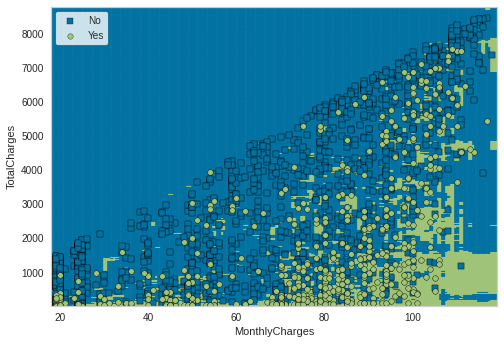

accuracy :  0.7873996204711051
recall :  0.47671574601080985
precision :  0.6369187463041835


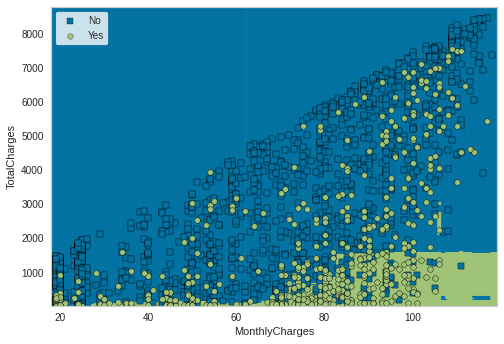

accuracy :  0.8004817408588029
recall :  0.482059038580092
precision :  0.6711718108931751


In [37]:
X,y = df_LE.loc[:, ["TotalCharges","MonthlyCharges"]].values, df_LE.loc[:, "Churn"].values
model_RFC = RandomForestClassifier()
model_list2.append(("RFC", model_RFC))

viz = DecisionViz(
    model_RFC, title="Random Forest",
    features=["MonthlyCharges","TotalCharges"], classes=['No', 'Yes']
)
viz.fit(x_train, y_train)
viz.draw(x_test, y_test)
viz.show()

acc = cross_val_score(model_RFC, X_LE, y_LE,scoring="accuracy").mean()
rec = cross_val_score(model_RFC, X_LE, y_LE,scoring="recall").mean()
prec = cross_val_score(model_RFC, X_LE, y_LE,scoring="precision").mean()

print("accuracy : ", acc)
print("recall : ", rec)
print("precision : ", prec)

model_RFC_enhan = RandomForestClassifier(
    criterion="entropy",
    max_depth=7,
    n_estimators = 334
    )
model_list2_enhanced.append(("RFC", model_RFC_enhan))

viz = DecisionViz(
    model_RFC_enhan, title="Random Forest tunned",
    features=["MonthlyCharges","TotalCharges"], classes=['No', 'Yes']
)
viz.fit(x_train, y_train)
viz.draw(x_test, y_test)
viz.show()

acc = cross_val_score(model_RFC_enhan, X_LE, y_LE,scoring="accuracy").mean()
rec = cross_val_score(model_RFC_enhan, X_LE, y_LE,scoring="recall").mean()
prec = cross_val_score(model_RFC_enhan, X_LE, y_LE,scoring="precision").mean()

print("accuracy : ", acc)
print("recall : ", rec)
print("precision : ", prec)

### Decision Tree

In [38]:
space = {
    'criterion' : hp.choice('criterion', ['gini', 'entropy']),
    'splitter' : hp.choice('splitter', ['best', 'random']),
    'class_weight' : hp.choice('class_weight', ['dict', 'list of dict', 'balanced']),
    'max_depth' : hp.choice("max_depth", range(1,30)),    
    }


def obj_fnc_DTree(params):
    # clf = models[model](**params)
    clf = DecisionTreeClassifier(**params)
    acc = cross_val_score(clf, X_LE, y_LE,scoring="accuracy").mean()
    return {"loss": -acc, "status": STATUS_OK}

trials = Trials()
best_params = fmin(
    obj_fnc_DTree, 
    space, 
    algo=tpe.suggest,
    max_evals=100,
    trials=trials)
print("Best: {}".format(best_params))

  4%|▍         | 4/100 [00:00<00:04, 20.60it/s, best loss: nan]

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py", line 942, in fit
    X_idx_sorted=X_idx_sorted,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py", line 221, in fit
    self.class_weight, y_original
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/class_weight.

  8%|▊         | 8/100 [00:00<00:04, 19.44it/s, best loss: nan]

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py", line 942, in fit
    X_idx_sorted=X_idx_sorted,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py", line 221, in fit
    self.class_weight, y_original
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/class_weight.

 15%|█▌        | 15/100 [00:00<00:05, 15.99it/s, best loss: nan]

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py", line 942, in fit
    X_idx_sorted=X_idx_sorted,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py", line 221, in fit
    self.class_weight, y_original
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/class_weight.

 24%|██▍       | 24/100 [00:01<00:04, 15.89it/s, best loss: nan]

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py", line 942, in fit
    X_idx_sorted=X_idx_sorted,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py", line 221, in fit
    self.class_weight, y_original
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/class_weight.

 29%|██▉       | 29/100 [00:01<00:03, 19.93it/s, best loss: nan]

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py", line 942, in fit
    X_idx_sorted=X_idx_sorted,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py", line 221, in fit
    self.class_weight, y_original
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/class_weight.

 32%|███▏      | 32/100 [00:01<00:03, 19.90it/s, best loss: nan]

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py", line 942, in fit
    X_idx_sorted=X_idx_sorted,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py", line 221, in fit
    self.class_weight, y_original
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/class_weight.

 38%|███▊      | 38/100 [00:02<00:03, 16.98it/s, best loss: nan]

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py", line 942, in fit
    X_idx_sorted=X_idx_sorted,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py", line 221, in fit
    self.class_weight, y_original
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/class_weight.

 44%|████▍     | 44/100 [00:02<00:02, 19.97it/s, best loss: nan]

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py", line 942, in fit
    X_idx_sorted=X_idx_sorted,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py", line 221, in fit
    self.class_weight, y_original
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/class_weight.

 56%|█████▌    | 56/100 [00:02<00:01, 32.77it/s, best loss: nan]

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py", line 942, in fit
    X_idx_sorted=X_idx_sorted,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py", line 221, in fit
    self.class_weight, y_original
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/class_weight.

 61%|██████    | 61/100 [00:02<00:01, 30.64it/s, best loss: nan]

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py", line 942, in fit
    X_idx_sorted=X_idx_sorted,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py", line 221, in fit
    self.class_weight, y_original
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/class_weight.

 70%|███████   | 70/100 [00:03<00:01, 28.50it/s, best loss: nan]

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py", line 942, in fit
    X_idx_sorted=X_idx_sorted,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py", line 221, in fit
    self.class_weight, y_original
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/class_weight.

 80%|████████  | 80/100 [00:03<00:00, 34.88it/s, best loss: nan]

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py", line 942, in fit
    X_idx_sorted=X_idx_sorted,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py", line 221, in fit
    self.class_weight, y_original
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/class_weight.

 90%|█████████ | 90/100 [00:03<00:00, 40.15it/s, best loss: nan]

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py", line 942, in fit
    X_idx_sorted=X_idx_sorted,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py", line 221, in fit
    self.class_weight, y_original
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/class_weight.

100%|██████████| 100/100 [00:03<00:00, 25.50it/s, best loss: nan]

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py", line 942, in fit
    X_idx_sorted=X_idx_sorted,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py", line 221, in fit
    self.class_weight, y_original
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/class_weight.

AssertionError: ignored

In [ ]:
X,y = df_LE.loc[:, ["TotalCharges","MonthlyCharges"]].values, df_LE.loc[:, "Churn"].values

model_DTree = DecisionTreeClassifier()
model_list2.append(("DTree", model_DTree))

viz = DecisionViz(
    model_DTree, title="Decision Tree",
    features=["MonthlyCharges","TotalCharges"], classes=['No', 'Yes']
)
viz.fit(x_train, y_train)
viz.draw(x_test, y_test)
viz.show()

acc = cross_val_score(model_DTree, X_LE, y_LE,scoring="accuracy").mean()
rec = cross_val_score(model_DTree, X_LE, y_LE,scoring="recall").mean()
prec = cross_val_score(model_DTree, X_LE, y_LE,scoring="precision").mean()

print("accuracy : ", acc)
print("recall : ", rec)
print("precision : ", prec)

model_DTree_enhan = DecisionTreeClassifier(
    class_weight='balanced',
    max_depth=3,
    criterion='gini',
    splitter='best'
    )
model_list2_enhanced.append(("DTree", model_DTree_enhan))

viz = DecisionViz(
    model_DTree_enhan, title="Decision Tree tunned",
    features=["MonthlyCharges","TotalCharges"], classes=['No', 'Yes']
)
viz.fit(x_train, y_train)
viz.draw(x_test, y_test)
viz.show()

acc = cross_val_score(model_DTree_enhan, X_LE, y_LE,scoring="accuracy").mean()
rec = cross_val_score(model_DTree_enhan, X_LE, y_LE,scoring="recall").mean()
prec = cross_val_score(model_DTree_enhan, X_LE, y_LE,scoring="precision").mean()

print("accuracy : ", acc)
print("recall : ", rec)
print("precision : ", prec)

### Gaussian Naive

In [ ]:
space = {
    'var_smoothing' : hp.uniform('var_smoothing', 0.0000000001, 0.1),    
    }


def obj_fnc_GNB(params):
    # clf = models[model](**params)
    clf = GaussianNB(**params)
    acc = cross_val_score(clf, X_LE, y_LE,scoring="accuracy").mean()
    return {"loss": -acc, "status": STATUS_OK}

trials = Trials()
best_params = fmin(
    obj_fnc_GNB, 
    space, 
    algo=tpe.suggest,
    max_evals=100,
    trials=trials)
print("Best: {}".format(best_params))

In [ ]:
X,y = df_LE.loc[:, ["TotalCharges","MonthlyCharges"]].values, df_LE.loc[:, "Churn"].values

model_GNB = GaussianNB()
model_list2.append(("GNB", model_GNB))

viz = DecisionViz(
    model_GNB, title="Naive Bayes",
    features=["MonthlyCharges","TotalCharges"], classes=['No', 'Yes']
)
viz.fit(x_train, y_train)
viz.draw(x_test, y_test)
viz.show()

acc = cross_val_score(model_GNB, X_LE, y_LE,scoring="accuracy").mean()
rec = cross_val_score(model_GNB, X_LE, y_LE,scoring="recall").mean()
prec = cross_val_score(model_GNB, X_LE, y_LE,scoring="precision").mean()

print("accuracy : ", acc)
print("recall : ", rec)
print("precision : ", prec)

model_GNB_enhan = GaussianNB(
    var_smoothing  = 0.04324584889894358
    )
model_list2_enhanced.append(("GNB", model_GNB_enhan))

viz = DecisionViz(
    model_GNB_enhan, title="Naive Bayes tunned",
    features=["MonthlyCharges","TotalCharges"], classes=['No', 'Yes']
)
viz.fit(x_train, y_train)
viz.draw(x_test, y_test)
viz.show()

acc = cross_val_score(model_GNB_enhan, X_LE, y_LE,scoring="accuracy").mean()
rec = cross_val_score(model_GNB_enhan, X_LE, y_LE,scoring="recall").mean()
prec = cross_val_score(model_GNB_enhan, X_LE, y_LE,scoring="precision").mean()

print("accuracy : ", acc)
print("recall : ", rec)
print("precision : ", prec)

### Majority voting

In [ ]:
from sklearn.ensemble import VotingClassifier

X,y = df_LE.loc[:, ["TotalCharges","MonthlyCharges"]].values, df_LE.loc[:, "Churn"].values

voting_model = VotingClassifier(estimators=model_list2)

viz = DecisionViz(
    voting_model, title="Majority voting",
    features=["MonthlyCharges","TotalCharges"], classes=['No', 'Yes']
)
viz.fit(x_train, y_train)
viz.draw(x_test, y_test)
viz.show()

acc = cross_val_score(voting_model , X_LE, y_LE,scoring="accuracy").mean()
rec = cross_val_score(voting_model , X_LE, y_LE,scoring="recall").mean()
prec = cross_val_score(voting_model , X_LE, y_LE,scoring="precision").mean()

print("accuracy : ", acc)
print("recall : ", rec)
print("precision : ", prec)

voting_model_enhan = VotingClassifier(estimators=model_list2_enhanced)
viz = DecisionViz(
    voting_model_enhan, title="Naive Bayes tunned",
    features=["MonthlyCharges","TotalCharges"], classes=['No', 'Yes']
)
viz.fit(x_train, y_train)
viz.draw(x_test, y_test)
viz.show()

acc = cross_val_score(voting_model_enhan, X_LE, y_LE,scoring="accuracy").mean()
rec = cross_val_score(voting_model_enhan, X_LE, y_LE,scoring="recall").mean()
prec = cross_val_score(voting_model_enhan, X_LE, y_LE,scoring="precision").mean()

print("accuracy : ", acc)
print("recall : ", rec)
print("precision : ", prec)